## Import libraries and load data

In [88]:
# Libraries to work with the data object
import pandas as pd 
import numpy as np

# libraries to visualize
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image

import graphviz
import pydotplus
import xgboost as xgb

# sklearn packages for Decision Tree
from sklearn import metrics
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc 
from sklearn.metrics import roc_auc_score

# sklearn packages for KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

# sklearn packages for Hyperparameter tuning
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# sklearn packages for RandomForest and Logistic Regression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier

# CodeCarbon library
from codecarbon import EmissionsTracker

# Sampling libraries
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek


#load our data
original_df = pd.read_csv("../data/heart_disease_health_indicators_BRFSS2015.csv", delimiter=",")

In [2]:
# Below, we make a list of features/independent variables 'X', and specify our target/dependent variable, y
# The model will guess/predict the 'y' feature (our target) based on the list of features, 'X'
# Running the cell will not produce any output. This is because we are defining X and y, which we will be using in the next section to train our model

X = original_df[['GenHlth', 'Age', 'DiffWalk', 'HighBP', 'Stroke', 'PhysHlth', 'HighChol', 'Diabetes', 'Income', 'Education', 'Smoker']].values

y = original_df['HeartDiseaseorAttack'].values

In [3]:
# split data into test and train - 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Extra functions

In [4]:
def evaluate_model(model, X_train, y_train):
    # Fit the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred)
    
    print(f"Model: {model.__class__.__name__}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"AUC-ROC: {auc_roc}")

In [5]:
def draw_confusion_matrix(y_true, y_pred):
    # Create a confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)

    # Create labels for the matrix
    group_names = ['True Negative','False Positive','False Negative','True Positive']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    # Create a heatmap from the confusion matrix
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

## Sample the imbalanced dataframe

### Oversampling

#### SMOTE

In [6]:
print("Count before:", Counter(y_train))
smoOverSam = SMOTE()
X_S, y_S = smoOverSam.fit_resample(X_train, y_train)
print("Count after:", Counter(y_S))

Count before: Counter({0.0: 183819, 1.0: 19125})
Count after: Counter({0.0: 183819, 1.0: 183819})


#### Random

In [7]:
print("Count before:", Counter(y_train))
ranOveSam = RandomOverSampler(sampling_strategy='minority')
X_ro, y_ro = ranOveSam.fit_resample(X_train, y_train)
print("Count after:", Counter(y_ro))

Count before: Counter({0.0: 183819, 1.0: 19125})
Count after: Counter({0.0: 183819, 1.0: 183819})


### Undersampling

#### Random

In [8]:
print("Count before:", Counter(y_train))
ranUndSam = RandomUnderSampler(sampling_strategy='majority')
X_ru, y_ru = ranUndSam.fit_resample(X_train, y_train)
print("Count after:", Counter(y_ru))

Count before: Counter({0.0: 183819, 1.0: 19125})
Count after: Counter({0.0: 19125, 1.0: 19125})


#### TomekLinks

In [9]:
print("Count before:", Counter(y_train))
tomLinUndSam = TomekLinks(sampling_strategy='auto')
X_T, y_T = tomLinUndSam.fit_resample(X_train, y_train)
print("Count after:", Counter(y_T))

Count before: Counter({0.0: 183819, 1.0: 19125})
Count after: Counter({0.0: 182258, 1.0: 19125})


### Combining oversampling and undersampling - SMOTE and TomekLinks

In [10]:
print("Count before:", Counter(y_train))
resample = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
reresample = SMOTE
X_ST, y_ST = resample.fit_resample(X_train, y_train)
print("Count after:", Counter(y_ST))

Count before: Counter({0.0: 183819, 1.0: 19125})
Count after: Counter({1.0: 183819, 0.0: 183786})


## Training models

### Decision tree

#### Oversampled

##### SMOTE

In [11]:
clf = DecisionTreeClassifier(criterion="entropy", max_depth=6).fit(X_S, y_S)
y_S_pred = clf.predict(X_test)

Model: DecisionTreeClassifier
Accuracy: 0.7732576474298328
Precision: 0.24084333641120345
Recall: 0.6564597315436241
F1 Score: 0.35239810853411396
AUC-ROC: 0.7209160822702458


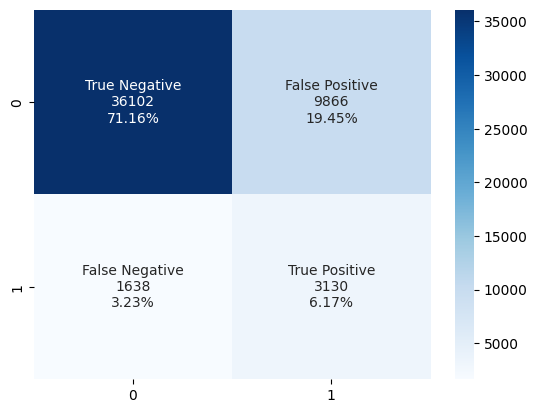

In [12]:
y_S_pred = clf.predict(X_test)
evaluate_model(clf, X_S, y_S)
draw_confusion_matrix(y_test, y_S_pred)

##### Random - <span style="color:red">**(BEST)**</span>

Model: DecisionTreeClassifier
Accuracy: 0.7150149795017344
Precision: 0.21924792861695347
Recall: 0.7936241610738255
F1 Score: 0.3435783356789395
AUC-ROC: 0.7502427279438046


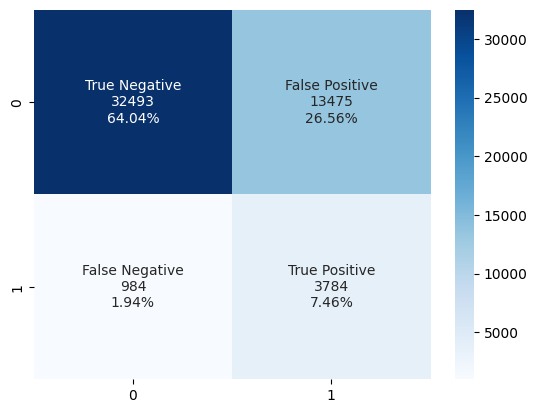

In [13]:
clf.fit(X_ro, y_ro)
y_ro_pred = clf.predict(X_test)
evaluate_model(clf, X_ro, y_ro)
draw_confusion_matrix(y_test, y_ro_pred)

#### Undersampled

##### Random

Model: DecisionTreeClassifier
Accuracy: 0.7169268369599495
Precision: 0.2201610080504025
Recall: 0.7915268456375839
F1 Score: 0.3445002282062985
AUC-ROC: 0.7503579233408944


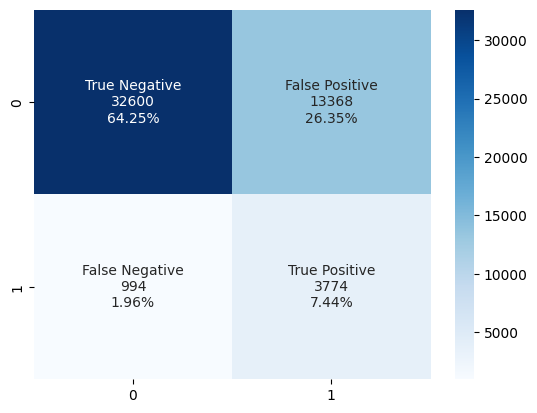

In [14]:
clf.fit(X_ru, y_ru)
y_ru_pred = clf.predict(X_test)
evaluate_model(clf, X_ru, y_ru)
draw_confusion_matrix(y_test, y_ru_pred)

##### TomekLinks

Model: DecisionTreeClassifier
Accuracy: 0.9077578051087984
Precision: 0.5785714285714286
Recall: 0.06795302013422819
F1 Score: 0.12162162162162163
AUC-ROC: 0.5314095069345002


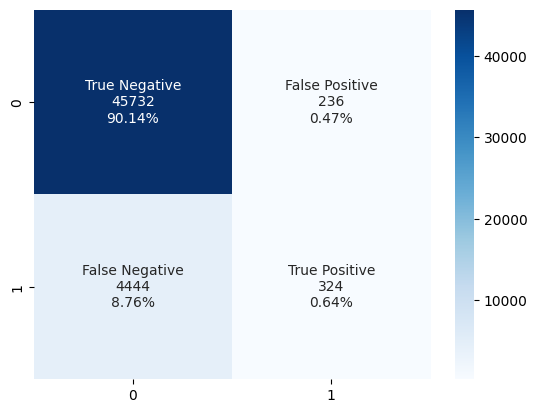

In [15]:
clf.fit(X_T, y_T)
y_tl_pred = clf.predict(X_test)
evaluate_model(clf, X_T, y_T)
draw_confusion_matrix(y_test, y_tl_pred)

##### Undersampled and Oversampled - TomekLinks and SMOTE

Model: DecisionTreeClassifier
Accuracy: 0.7601900031535793
Precision: 0.23625864404363014
Recall: 0.6950503355704698
F1 Score: 0.3526469805799415
AUC-ROC: 0.7309984535492446


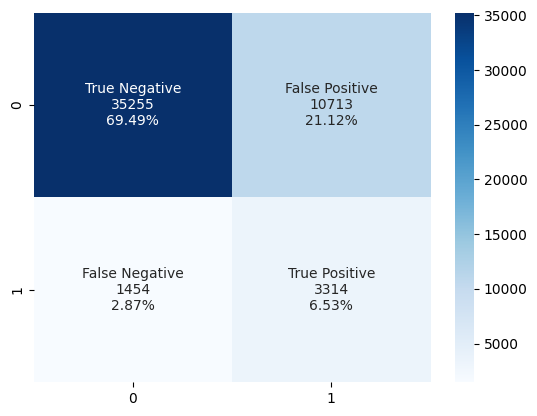

In [16]:
clf.fit(X_ST, y_ST)
y_st_pred = clf.predict(X_test)
evaluate_model(clf, X_ST, y_ST)
draw_confusion_matrix(y_test, y_st_pred)

### K-NN

In [17]:
clf2 = KNeighborsClassifier()
scaler = StandardScaler()

#### Oversampled

##### SMOTE

Model: KNeighborsClassifier
Accuracy: 0.8181764427625354
Precision: 0.23993464815030927
Recall: 0.4312080536912752
F1 Score: 0.308315213316338
AUC-ROC: 0.6447612666646422


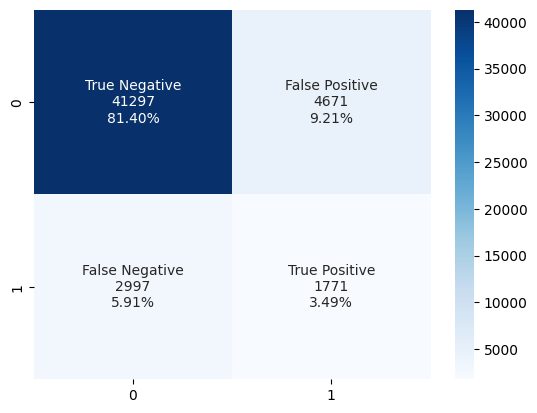

In [18]:
scaler.fit(X_S)
X_train_std = scaler.transform(X_S)

clf2.fit(X_train_std, y_S)

X_test_std = scaler.transform(X_test)

y_S_pred_2 = clf2.predict(X_test_std)

evaluate_model(clf2, X_S, y_S)
draw_confusion_matrix(y_test, y_S_pred_2)


##### Random

Model: KNeighborsClassifier
Accuracy: 0.8560391043834752
Precision: 0.27652449770884735
Recall: 0.3290687919463087
F1 Score: 0.30051714230990234
AUC-ROC: 0.6198837694503558


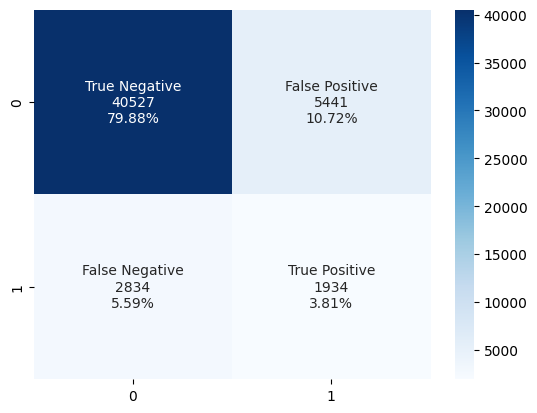

In [19]:
scaler.fit(X_ro)
X_train_std2 = scaler.transform(X_ro)

clf2.fit(X_train_std2, y_ro)

X_test_std2 = scaler.transform(X_test)

y_ro_pred_2 = clf2.predict(X_test_std2)

evaluate_model(clf2, X_ro, y_ro)
draw_confusion_matrix(y_test, y_ro_pred_2)


#### Undersampled

##### Random

Model: KNeighborsClassifier
Accuracy: 0.7828169347209082
Precision: 0.23617793534228074
Recall: 0.5868288590604027
F1 Score: 0.33680409268733075
AUC-ROC: 0.6949872628055233


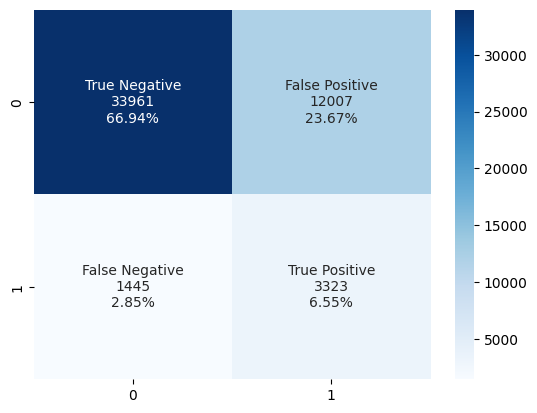

In [20]:
scaler.fit(X_ru)
X_train_std3 = scaler.transform(X_ru)

clf2.fit(X_train_std3, y_ru)

X_test_std3 = scaler.transform(X_test)

y_ru_pred_3 = clf2.predict(X_test_std3)

evaluate_model(clf2, X_ru, y_ru)
draw_confusion_matrix(y_test, y_ru_pred_3)

##### Tomeklinks

Model: KNeighborsClassifier
Accuracy: 0.8965231788079471
Precision: 0.3653631284916201
Recall: 0.13716442953020133
F1 Score: 0.19945105215004574
AUC-ROC: 0.5562257929064164


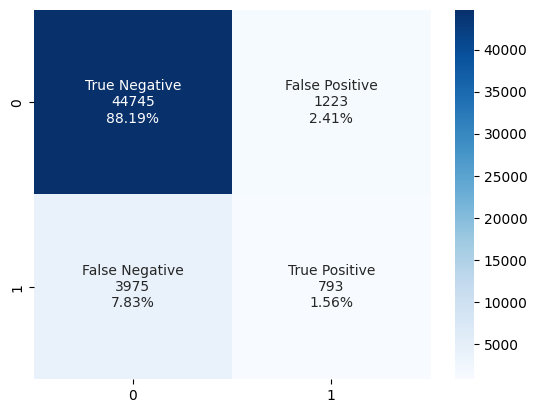

In [21]:
scaler.fit(X_T)
X_train_std_tl = scaler.transform(X_T)
clf2.fit(X_train_std_tl, y_T)
X_test_std_tl = scaler.transform(X_test)
y_tl_pred = clf2.predict(X_test_std_tl)
evaluate_model(clf2, X_T, y_T)
draw_confusion_matrix(y_test, y_tl_pred)

##### Undersampled and Oversampled - TomekLinks and SMOTE

Model: KNeighborsClassifier
Accuracy: 0.8177034058656575
Precision: 0.2389607363392753
Recall: 0.43015939597315433
F1 Score: 0.30724290315332187
AUC-ROC: 0.6440302722991426


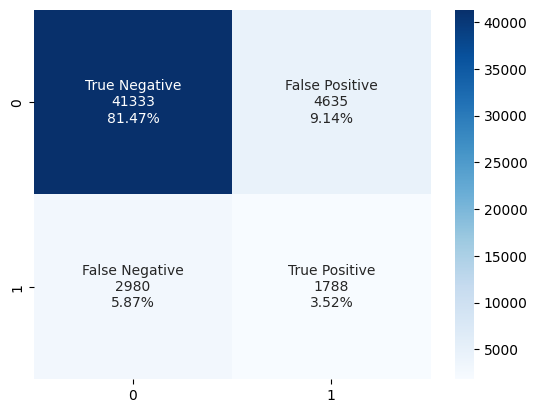

In [22]:
# Apply SMOTETomek oversampling and undersampling
scaler.fit(X_ST)
X_train_std_ST = scaler.transform(X_ST)
clf2.fit(X_train_std_ST, y_ST)
X_test_std_ST = scaler.transform(X_test)
y_ST_pred = clf2.predict(X_test_std_ST)
evaluate_model(clf2, X_ST, y_ST)
draw_confusion_matrix(y_test, y_ST_pred)

### Hyperparameter tuning

#### GridSearch with LinearSVC

In [23]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
gridSearch = GridSearchCV(LinearSVC(dual=False), param_grid, scoring='accuracy', cv=5)

##### Oversampling

##### SMOTE

Model: DecisionTreeClassifier
Accuracy: 0.7732576474298328
Precision: 0.24084333641120345
Recall: 0.6564597315436241
F1 Score: 0.35239810853411396
AUC-ROC: 0.7209160822702458


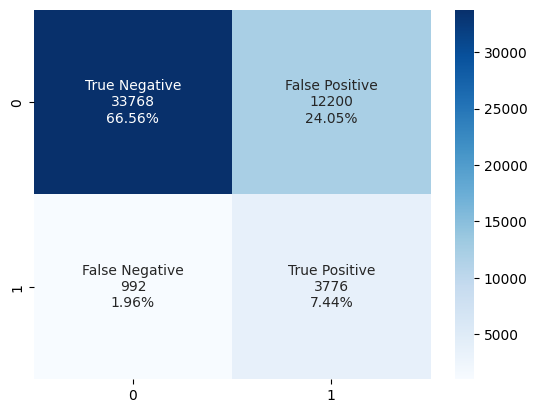

In [31]:
gridSearch.fit(X_S, y_S)
clf3 = LinearSVC(C=float(gridSearch.best_params_['C']), dual=False)
clf3.fit(X_S, y_S)
y_S_pred3 = clf3.predict(X_test)
evaluate_model(clf, X_S, y_S)
draw_confusion_matrix(y_test, y_S_pred3)

##### Random

Model: LinearSVC
Accuracy: 0.7396917376222012
Precision: 0.23675837544450684
Recall: 0.7959312080536913
F1 Score: 0.36495648410828485
AUC-ROC: 0.7648947721437966


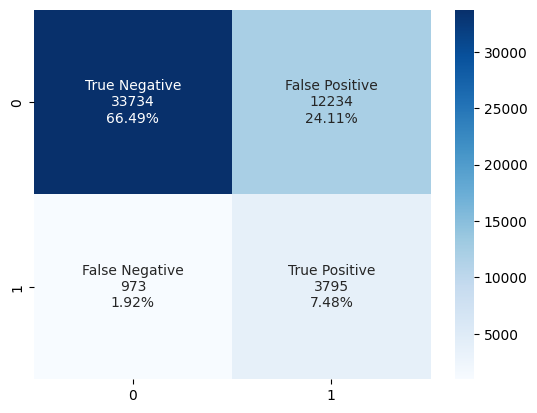

In [32]:
gridSearch.fit(X_ro, y_ro)
clf_ro = LinearSVC(C=float(gridSearch.best_params_['C']), dual=False)
clf_ro.fit(X_ro, y_ro)
y_ro_pred = clf_ro.predict(X_test)
evaluate_model(clf_ro, X_ro, y_ro)
draw_confusion_matrix(y_test, y_ro_pred)

##### Undersampling

##### Random

Model: LinearSVC
Accuracy: 0.7388639230526648
Precision: 0.236402063778206
Recall: 0.7976090604026845
F1 Score: 0.3647087029489331
AUC-ROC: 0.7651898417224005


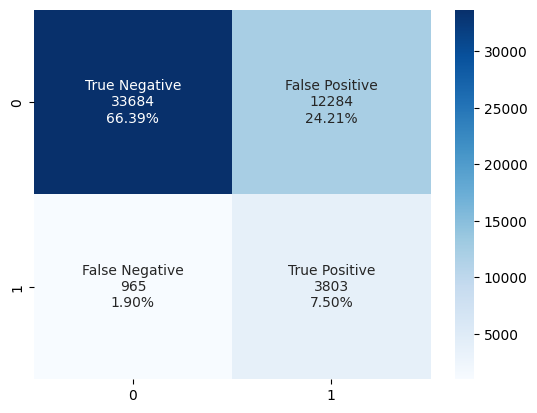

In [33]:
gridSearch.fit(X_ru, y_ru)
clf_ru = LinearSVC(C=float(gridSearch.best_params_['C']), dual=False)
clf_ru.fit(X_ru, y_ru)
y_ru_pred = clf_ru.predict(X_test)
evaluate_model(clf_ru, X_ru, y_ru)
draw_confusion_matrix(y_test, y_ru_pred)

##### Tomeklinks

Model: LinearSVC
Accuracy: 0.9076789656259855
Precision: 0.6129032258064516
Recall: 0.047818791946308725
F1 Score: 0.088715953307393
AUC-ROC: 0.5223430889769831


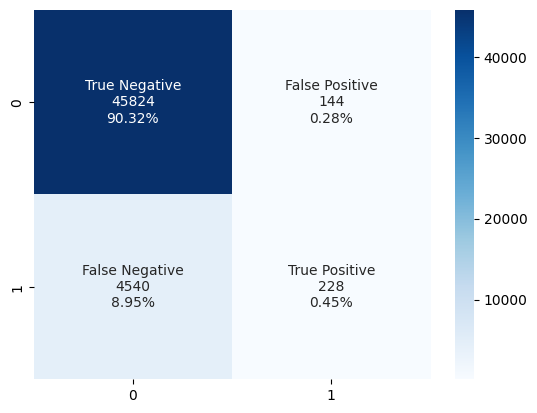

In [35]:
# For TomekLinks undersampling
gridSearch.fit(X_T, y_T)
clf_tl = LinearSVC(C=float(gridSearch.best_params_['C']), dual=False)
clf_tl.fit(X_T, y_T)
y_tl_pred = clf_tl.predict(X_test)
evaluate_model(clf_tl, X_T, y_T)
draw_confusion_matrix(y_test, y_tl_pred)

##### Oversampling and undersampling - SMOTE and Tomeklinks

Model: LinearSVC
Accuracy: 0.7395537685272785
Precision: 0.2362932434120145
Recall: 0.7936241610738255
F1 Score: 0.36416129342700415
AUC-ROC: 0.7637847571815352


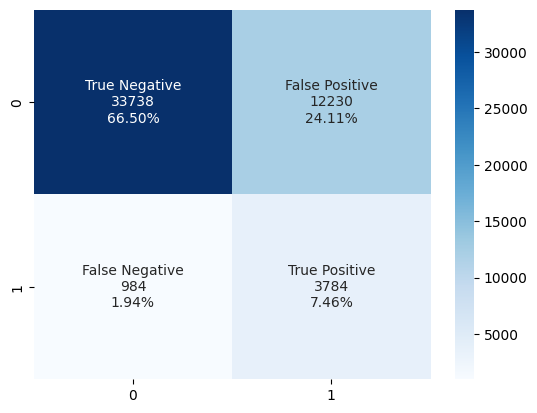

In [36]:
smote_tomek = SMOTETomek(random_state=42)
X_st, y_st = smote_tomek.fit_resample(X, y)
gridSearch.fit(X_st, y_st)
clf_st = LinearSVC(C=float(gridSearch.best_params_['C']), dual=False)
clf_st.fit(X_st, y_st)
y_st_pred = clf_st.predict(X_test)
evaluate_model(clf_st, X_st, y_st)
draw_confusion_matrix(y_test, y_st_pred)

### RandomSearch

In [42]:
param_distributions = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
randomSearch = RandomizedSearchCV(LinearSVC(dual=False), param_distributions, random_state=0)

##### Oversampling

##### SMOTE

c:\Users\u4025041\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Model: LinearSVC
Accuracy: 0.7399873856827499
Precision: 0.23635453179769655
Recall: 0.7919463087248322
F1 Score: 0.3640570767450829
AUC-ROC: 0.7632721449645741


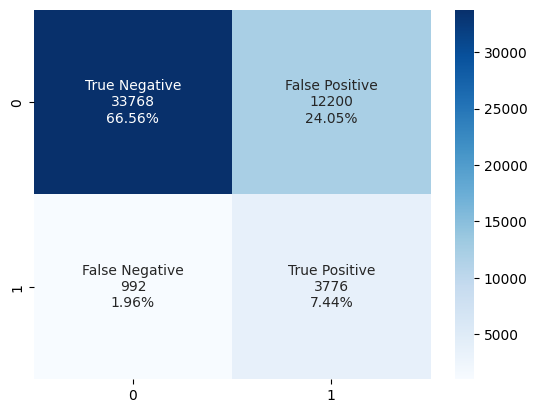

In [43]:
randomSearch.fit(X_S, y_S)
clf_S = LinearSVC(C=float(randomSearch.best_params_['C']), dual=False)
clf_S.fit(X_S, y_S)
y_S_pred = clf_S.predict(X_test)
evaluate_model(clf_S, X_S, y_S)
draw_confusion_matrix(y_test, y_S_pred)

##### Random

c:\Users\u4025041\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Model: LinearSVC
Accuracy: 0.7396917376222012
Precision: 0.23675837544450684
Recall: 0.7959312080536913
F1 Score: 0.36495648410828485
AUC-ROC: 0.7648947721437966


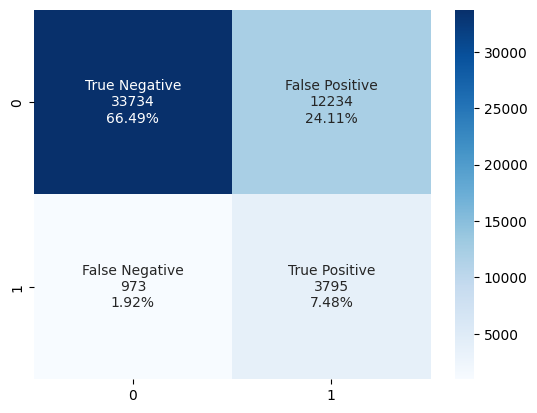

In [44]:
randomSearch.fit(X_ro, y_ro)
clf_ro = LinearSVC(C=float(randomSearch.best_params_['C']), dual=False)
clf_ro.fit(X_ro, y_ro)
y_ro_pred = clf_ro.predict(X_test)
evaluate_model(clf_ro, X_ro, y_ro)
draw_confusion_matrix(y_test, y_ro_pred)

##### Undersampling

##### Random

c:\Users\u4025041\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Model: LinearSVC
Accuracy: 0.7388639230526648
Precision: 0.236402063778206
Recall: 0.7976090604026845
F1 Score: 0.3647087029489331
AUC-ROC: 0.7651898417224005


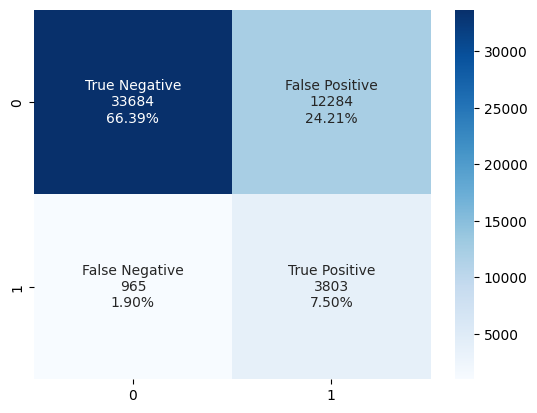

In [45]:
randomSearch.fit(X_ru, y_ru)
clf_ru = LinearSVC(C=float(randomSearch.best_params_['C']), dual=False)
clf_ru.fit(X_ru, y_ru)
y_ru_pred = clf_ru.predict(X_test)
evaluate_model(clf_ru, X_ru, y_ru)
draw_confusion_matrix(y_test, y_ru_pred)

##### Tomeklinks

c:\Users\u4025041\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Model: LinearSVC
Accuracy: 0.9076789656259855
Precision: 0.6129032258064516
Recall: 0.047818791946308725
F1 Score: 0.088715953307393
AUC-ROC: 0.5223430889769831


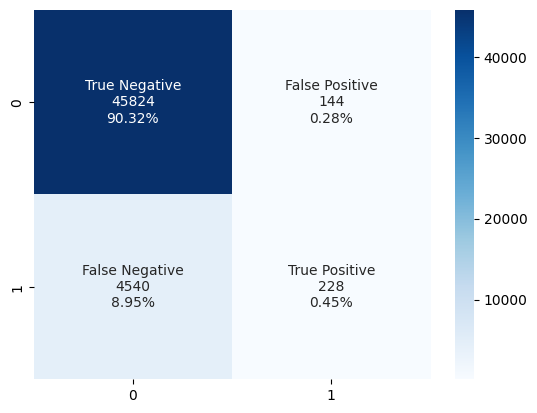

In [47]:
randomSearch.fit(X_T, y_T)
clf_tl = LinearSVC(C=float(randomSearch.best_params_['C']), dual=False)
clf_tl.fit(X_T, y_T)
y_tl_pred = clf_tl.predict(X_test)
evaluate_model(clf_tl, X_T, y_T)
draw_confusion_matrix(y_test, y_tl_pred)

##### Oversampling and Undersampling

c:\Users\u4025041\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Model: LinearSVC
Accuracy: 0.7395537685272785
Precision: 0.2360625
Recall: 0.7921560402684564
F1 Score: 0.3637326656394453
AUC-ROC: 0.7631268367022755


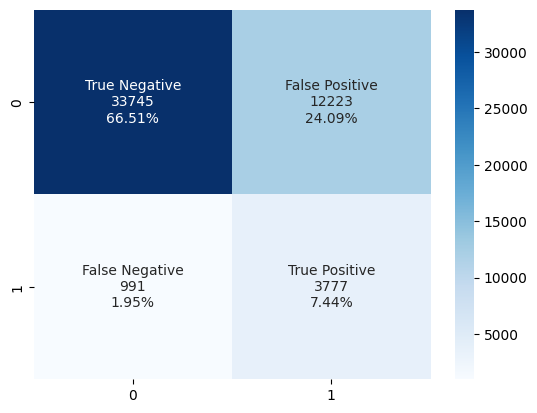

In [48]:
randomSearch.fit(X_ST, y_ST)
clf_ST = LinearSVC(C=float(randomSearch.best_params_['C']), dual=False)
clf_ST.fit(X_ST, y_ST)
y_ST_pred = clf_ST.predict(X_test)
evaluate_model(clf_ST, X_ST, y_ST)
draw_confusion_matrix(y_test, y_ST_pred)

### Ensemble methods

In [53]:
scaler = StandardScaler()
clf4 = RandomForestClassifier(n_estimators = 5, max_depth = 5)

#### Bagging - RandomForest

##### Oversampling

##### SMOTE

Model: RandomForestClassifier
Accuracy: 0.7643882056133712
Precision: 0.23967540936096218
Recall: 0.6937919463087249
F1 Score: 0.3562735595045773
AUC-ROC: 0.7327513508083825


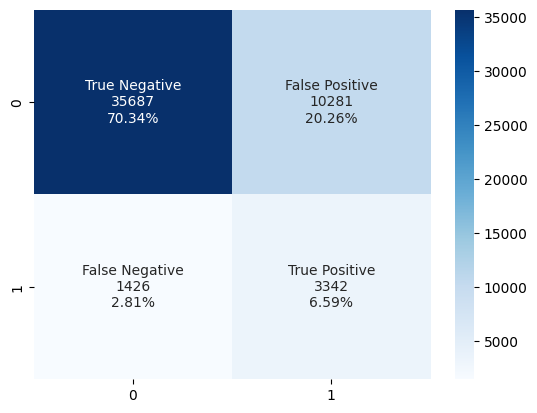

In [52]:
scaler.fit(X_S)
X_train_std = scaler.transform(X_S)
X_test_std = scaler.transform(X_test)
clf4.fit(X_S, y_S)
y_S_pred4 = clf4.predict(X_test)
evaluate_model(clf4, X_S, y_S)
draw_confusion_matrix(y_test, y_S_pred4)

##### Random

Model: RandomForestClassifier
Accuracy: 0.7089049195837275
Precision: 0.21621928380909142
Recall: 0.7990771812080537
F1 Score: 0.3403457054803698
AUC-ROC: 0.749314521686519


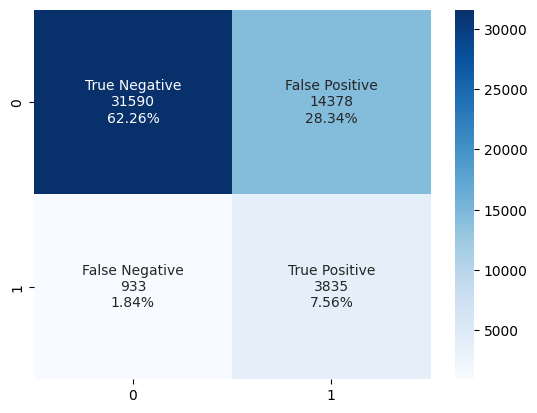

In [55]:
scaler.fit(X_ro)
X_train_std = scaler.transform(X_ro)
X_test_std = scaler.transform(X_test)
clf4.fit(X_ro, y_ro)
y_ro_pred4 = clf4.predict(X_test)
evaluate_model(clf4, X_ro, y_ro)
draw_confusion_matrix(y_test, y_ro_pred4)

##### Undersampling

##### Random

Model: RandomForestClassifier
Accuracy: 0.7180897193314412
Precision: 0.21874815645094683
Recall: 0.7776845637583892
F1 Score: 0.34145218472305355
AUC-ROC: 0.7447964238910288


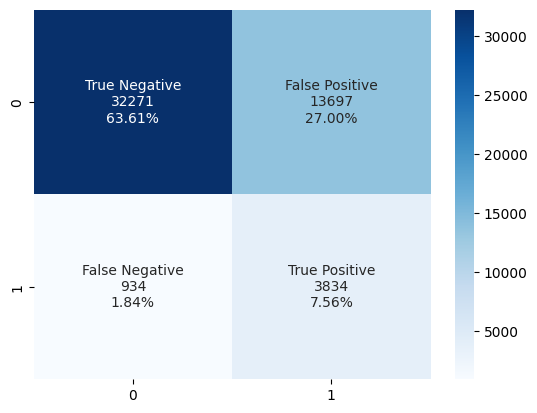

In [56]:
scaler.fit(X_ru)
X_train_std = scaler.transform(X_ru)
X_test_std = scaler.transform(X_test)
clf4.fit(X_ru, y_ru)
y_ru_pred4 = clf4.predict(X_test)
evaluate_model(clf4, X_ru, y_ru)
draw_confusion_matrix(y_test, y_ru_pred4)

##### TomekLinks

Model: RandomForestClassifier
Accuracy: 0.9067526017029328
Precision: 0.7402597402597403
Recall: 0.011954697986577181
F1 Score: 0.023529411764705882
AUC-ROC: 0.5057598063549316


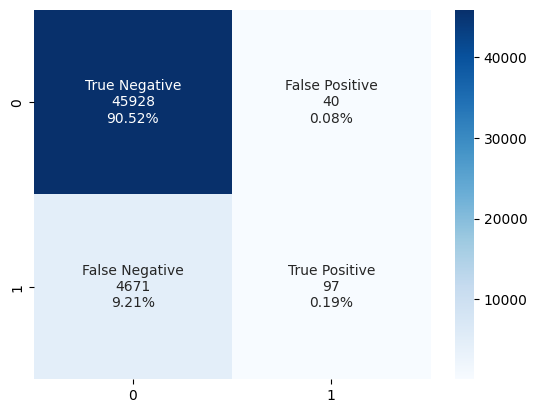

In [58]:
scaler.fit(X_T)
X_train_std = scaler.transform(X_T)
X_test_std = scaler.transform(X_test)
clf4.fit(X_T, y_T)
y_tl_pred4 = clf4.predict(X_test)
evaluate_model(clf4, X_T, y_T)
draw_confusion_matrix(y_test, y_tl_pred4)

##### Oversampling and undersampling

Model: RandomForestClassifier
Accuracy: 0.7625157678965626
Precision: 0.24193662720635145
Recall: 0.7158137583892618
F1 Score: 0.3616423841059603
AUC-ROC: 0.7415868304650799


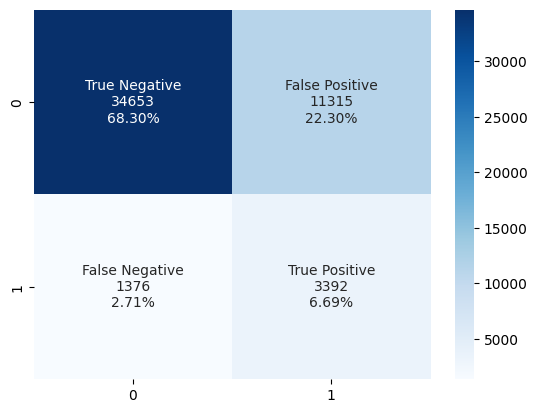

In [59]:
scaler.fit(X_st)
X_train_std = scaler.transform(X_st)
X_test_std = scaler.transform(X_test)
clf4.fit(X_st, y_st)
y_st_pred4 = clf4.predict(X_test)
evaluate_model(clf4, X_st, y_st)
draw_confusion_matrix(y_test, y_st_pred4)

#### Boosting

#### AdaBoost

In [60]:
clf5 = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 2, random_state=55), n_estimators = 2)

##### Oversampled

##### SMOTE

c:\Users\u4025041\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\u4025041\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Model: AdaBoostClassifier
Accuracy: 0.699247082939136
Precision: 0.2015023046719399
Recall: 0.7426593959731543
F1 Score: 0.3169956582068842
AUC-ROC: 0.7187017829152232


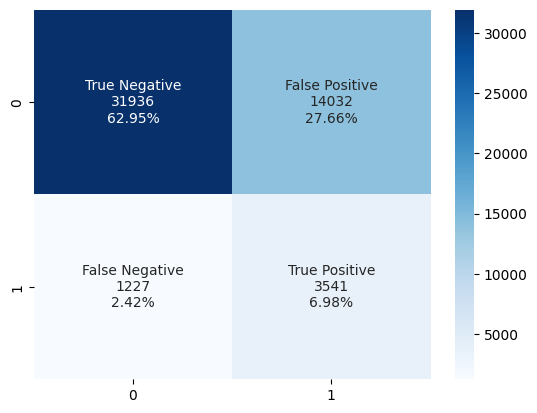

In [62]:
clf5.fit(X_S, y_S)
y_S_pred5 = clf5.predict(X_test)
evaluate_model(clf5, X_S, y_S)
draw_confusion_matrix(y_test, y_S_pred5)

##### Random - <span style="color:red">**(Maybe also BEST?)**</span>

c:\Users\u4025041\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\u4025041\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Model: AdaBoostClassifier
Accuracy: 0.6603792179123305
Precision: 0.1917997922745932
Recall: 0.8133389261744967
F1 Score: 0.3104014087325409
AUC-ROC: 0.728926250417565


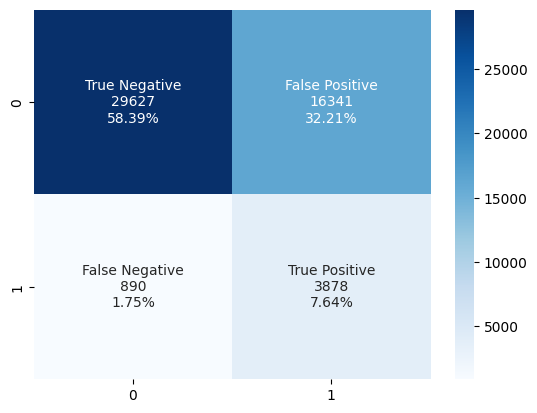

In [63]:
clf5.fit(X_ro, y_ro)
y_ro_pred5 = clf5.predict(X_test)
evaluate_model(clf5, X_ro, y_ro)
draw_confusion_matrix(y_test, y_ro_pred5)

##### Undersampled

##### Random

c:\Users\u4025041\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\u4025041\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Model: AdaBoostClassifier
Accuracy: 0.6997201198360139
Precision: 0.20767469139250405
Recall: 0.7797818791946308
F1 Score: 0.3279961183891315
AUC-ROC: 0.7355988233425294


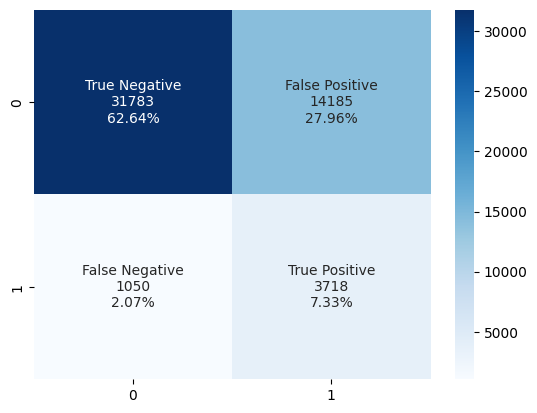

In [64]:
clf5.fit(X_ru, y_ru)
y_ru_pred5 = clf5.predict(X_test)
evaluate_model(clf5, X_ru, y_ru)
draw_confusion_matrix(y_test, y_ru_pred5)

##### TomekLinks

c:\Users\u4025041\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\u4025041\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Model: AdaBoostClassifier
Accuracy: 0.9073833175654368
Precision: 0.5577889447236181
Recall: 0.06984060402684564
F1 Score: 0.12413793103448276
AUC-ROC: 0.5320487391871088


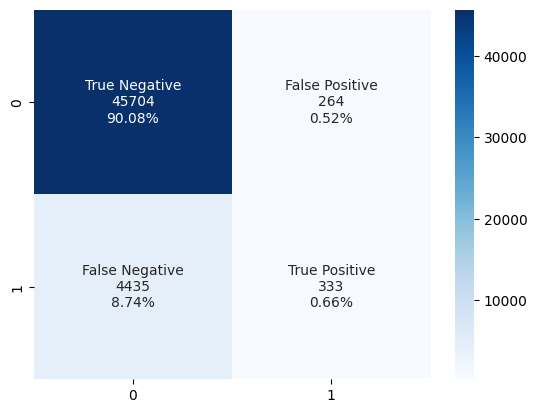

In [65]:
clf5.fit(X_T, y_T)
y_tl_pred5 = clf5.predict(X_test)
evaluate_model(clf5, X_T, y_T)
draw_confusion_matrix(y_test, y_tl_pred5)

##### Oversampled and undersampled

c:\Users\u4025041\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\u4025041\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Model: AdaBoostClassifier
Accuracy: 0.699247082939136
Precision: 0.2015023046719399
Recall: 0.7426593959731543
F1 Score: 0.3169956582068842
AUC-ROC: 0.7187017829152232


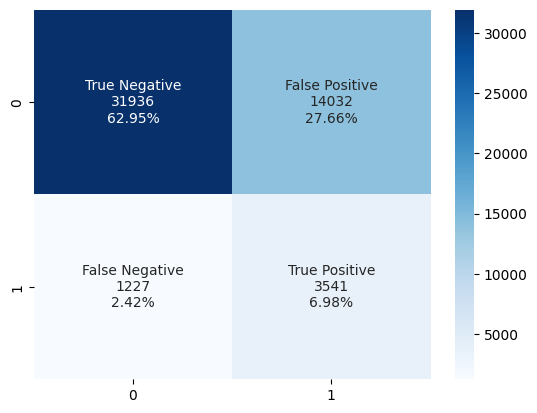

In [66]:
clf5.fit(X_st, y_st)
y_st_pred5 = clf5.predict(X_test)
evaluate_model(clf5, X_st, y_st)
draw_confusion_matrix(y_test, y_st_pred5)

#### XGBoost

In [69]:
clf6 = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic')

##### Oversampled

Model: XGBClassifier
Accuracy: 0.7446586250394197
Precision: 0.22395306494031963
Recall: 0.696518456375839
F1 Score: 0.33892942797366943
AUC-ROC: 0.7230851940772338


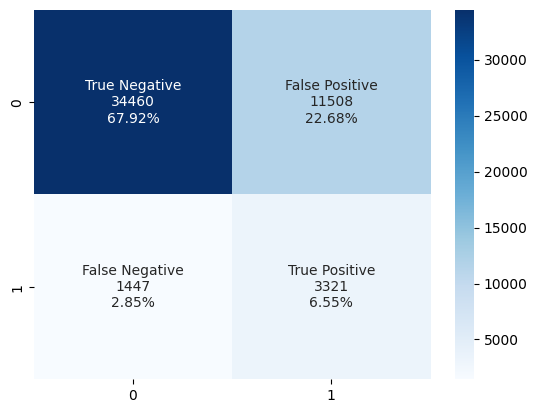

In [70]:
clf6.fit(X_S, y_S)
preds = clf6.predict(X_test)
evaluate_model(clf6, X_S, y_S)
draw_confusion_matrix(y_test, preds)

##### Random

Model: XGBClassifier
Accuracy: 0.6815081993062125
Precision: 0.20132151659761918
Recall: 0.8051593959731543
F1 Score: 0.32210429164743887
AUC-ROC: 0.7369209788776319


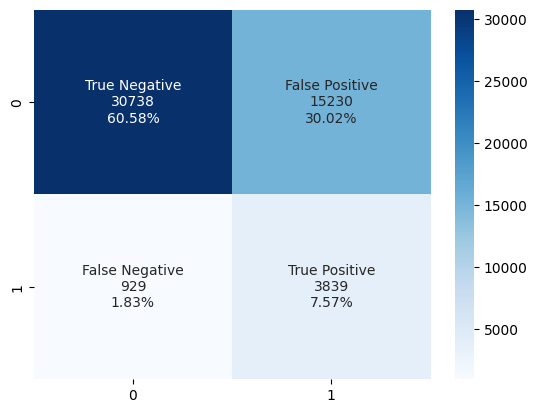

In [71]:
clf6.fit(X_ro, y_ro)
preds_ro = clf6.predict(X_test)
evaluate_model(clf6, X_ro, y_ro)
draw_confusion_matrix(y_test, preds_ro)

##### Undersampled

##### Random

Model: XGBClassifier
Accuracy: 0.6972563859981078
Precision: 0.20785525154457193
Recall: 0.790268456375839
F1 Score: 0.32914046121593293
AUC-ROC: 0.7389386138475088


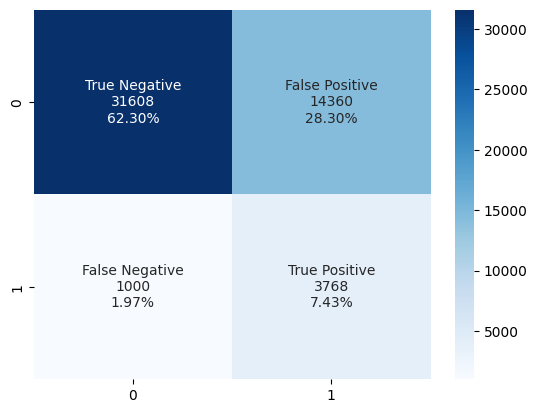

In [72]:
clf6.fit(X_ru, y_ru)
preds_ru = clf6.predict(X_test)
evaluate_model(clf6, X_ru, y_ru)
draw_confusion_matrix(y_test, preds_ru)

##### TomekLinks

Model: XGBClassifier
Accuracy: 0.9063584042888678
Precision: 0.5095398428731762
Recall: 0.09521812080536912
F1 Score: 0.16045237674500795
AUC-ROC: 0.5428557537545815


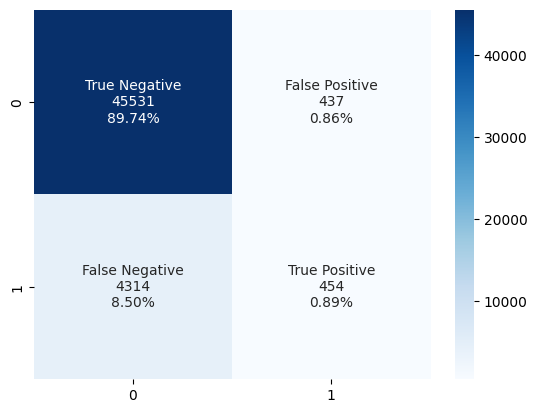

In [75]:
clf6.fit(X_T, y_T)
preds_tl = clf6.predict(X_test)
evaluate_model(clf6, X_T, y_T)
draw_confusion_matrix(y_test, preds_tl)

##### Oversampling and undersampling

Model: XGBClassifier
Accuracy: 0.7085304320403658
Precision: 0.20456421747847622
Recall: 0.7275587248322147
F1 Score: 0.3193408818926632
AUC-ROC: 0.7170577299761492


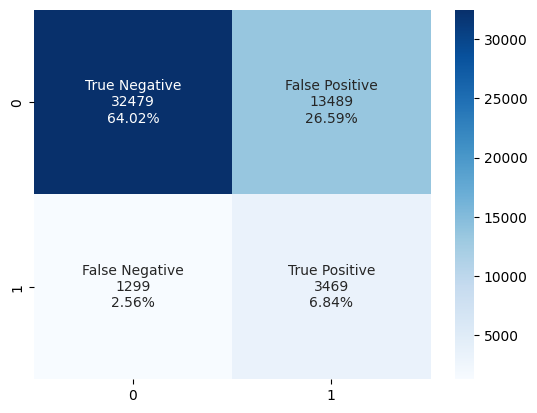

In [74]:
clf6.fit(X_st, y_st)
preds_st = clf6.predict(X_test)
evaluate_model(clf6, X_st, y_st)
draw_confusion_matrix(y_test, preds_st)

#### Voting

In [89]:
model_LR = LogisticRegression(solver='liblinear')
model_KNN = KNeighborsClassifier()
model_DT = DecisionTreeClassifier()

clf7 = VotingClassifier(estimators= [("model_LR",model_LR),("model_KNN", model_KNN),("model_DT", model_DT)], voting = 'hard')

tracker = EmissionsTracker()

[codecarbon WARNING @ 15:36:13] Invalid gpu_ids format. Expected a string or a list of ints.
[codecarbon INFO @ 15:36:13] [setup] RAM Tracking...
[codecarbon INFO @ 15:36:13] [setup] GPU Tracking...
[codecarbon INFO @ 15:36:13] No GPU found.
[codecarbon INFO @ 15:36:13] [setup] CPU Tracking...
[codecarbon WARNING @ 15:36:13] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 15:36:15] CPU Model on constant consumption mode: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz
[codecarbon INFO @ 15:36:15] >>> Tracker's metadata:
[codecarbon INFO @ 15:36:15]   Platform system: Windows-10-10.0.19045-SP0
[codecarbon INFO @ 15:36:15]   Python version: 3.11.5
[codecarbon INFO @ 15:36:15]   CodeCarbon version: 2.4.1
[codecarbon INFO @ 15:36:15]   Available RAM : 31.208 GB
[codecarbon INFO @ 15:36:15]   CPU count: 16
[codecarbon INFO @ 15:36:15]   CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz
[codecarbon INFO @ 15:36:15]   GPU count: None
[codecarbon INFO @

##### Oversampled

##### SMOTE

Model: VotingClassifier
Accuracy: 0.8239317250078839
Precision: 0.2697622996130459
Recall: 0.511744966442953
F1 Score: 0.3532903786288279
AUC-ROC: 0.6840290269040383


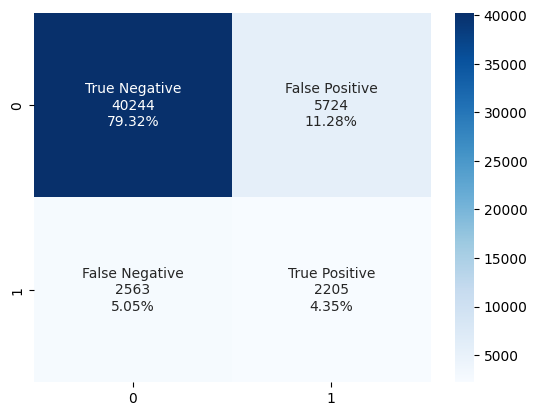

In [81]:
scaler.fit(X_S)
X_train_std = scaler.transform(X_S)
X_test_std = scaler.transform(X_test)
clf7.fit(X_train_std, y_S)
y_pred_VC = clf7.predict(X_test_std)
evaluate_model(clf7, X_S, y_S)
draw_confusion_matrix(y_test, y_pred_VC)

##### Random

Model: VotingClassifier
Accuracy: 0.8242865026805424
Precision: 0.26348808030112925
Recall: 0.48447986577181207
F1 Score: 0.34133727373476175
AUC-ROC: 0.6720062920923106


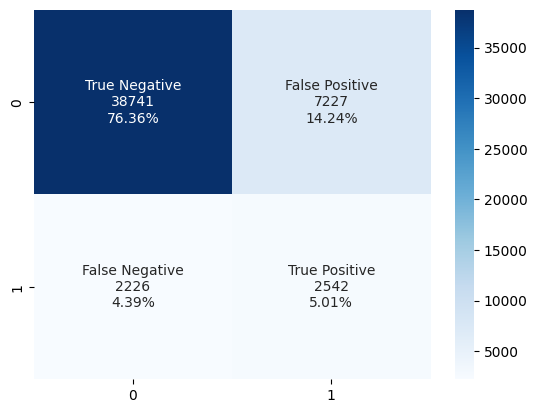

In [82]:
scaler.fit(X_ro)
X_train_std = scaler.transform(X_ro)
X_test_std = scaler.transform(X_test)
clf7.fit(X_train_std, y_ro)
y_pred_VC_ro = clf7.predict(X_test_std)
evaluate_model(clf7, X_ro, y_ro)
draw_confusion_matrix(y_test, y_pred_VC_ro)

##### Undersampled

##### Random

Model: VotingClassifier
Accuracy: 0.7572729422894986
Precision: 0.23661617924199066
Recall: 0.7109899328859061
F1 Score: 0.35506677140612725
AUC-ROC: 0.736531774657363


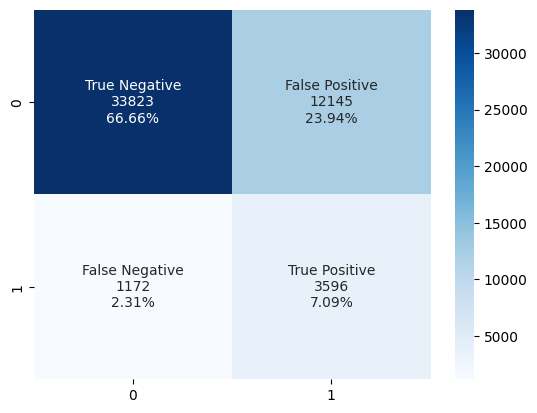

In [83]:
scaler.fit(X_ru)
X_train_std = scaler.transform(X_ru)
X_test_std = scaler.transform(X_test)
clf7.fit(X_train_std, y_ru)
y_pred_VC_ru = clf7.predict(X_test_std)
evaluate_model(clf7, X_ru, y_ru)
draw_confusion_matrix(y_test, y_pred_VC_ru)

##### TomekLinks

Model: VotingClassifier
Accuracy: 0.9031654052349417
Precision: 0.4463360473723168
Recall: 0.12646812080536912
F1 Score: 0.19709102794574276
AUC-ROC: 0.5550979657281283


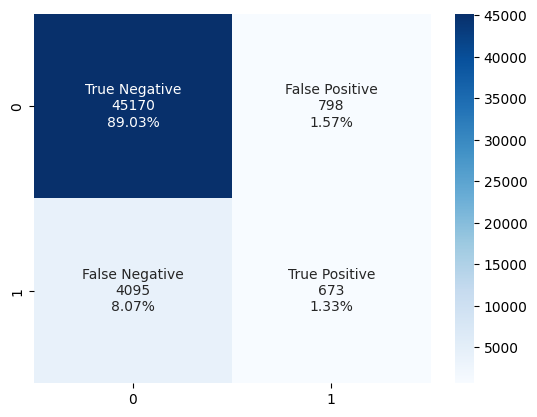

In [84]:
scaler.fit(X_T)
X_train_std = scaler.transform(X_T)
X_test_std = scaler.transform(X_test)
clf7.fit(X_train_std, y_T)
y_pred_VC_tl = clf7.predict(X_test_std)
evaluate_model(clf7, X_T, y_T)
draw_confusion_matrix(y_test, y_pred_VC_tl)

##### Oversampling and undersampling - <span style="color:red">**(I THINK THIS IS THE BEST ONE?)**</span>

In [94]:
tracker.start()

scaler.fit(X_st)
X_train_std = scaler.transform(X_st)
X_test_std = scaler.transform(X_test)
clf7.fit(X_train_std, y_st)
y_pred_VC_st = clf7.predict(X_test_std)

tracker.stop()

evaluate_model(clf7, X_st, y_st)
draw_confusion_matrix(y_test, y_pred_VC_st)

[codecarbon WARNING @ 15:44:19] Already started tracking


## Emission tracker

In [93]:
csv = pd.read_csv("emissions.csv")
csv

,timestamp,project_name,run_id,duration,emissions,emissions_rate,cpu_power,gpu_power,ram_power,cpu_energy,...,cpu_count,cpu_model,gpu_count,gpu_model,longitude,latitude,ram_total_size,tracking_mode,on_cloud,pue
0,2024-05-11T15:38:07,codecarbon,d9b71025-a308-4318-91af-b5198a931d39,37.638627,0.000064,0.000002,22.5,0.0,11.703142,0.000235,...,16,11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz,NaN,NaN,12.0564,55.7123,31.208378,machine,N,1.0
